In [8]:
import time
import numpy as np
from scipy import stats
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub, TUDataset, Planetoid
from torch_geometric.nn import GCNConv, SplineConv
from torch_geometric import utils
from torch_geometric.utils.convert import to_networkx
import torch_geometric.transforms as T
import networkx as nx

#%%script false --no-raise-error

class GCN(torch.nn.Module):
    def __init__(self, lst_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(lst_dim[0], lst_dim[1], bias=False, cached=True)
        self.conv2 = GCNConv(lst_dim[1], lst_dim[2], bias=False, cached=True)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        s1 = self.conv1(x, edge_index)
        a1 = F.dropout(F.relu(s1), .5, training=self.training)
        a1.retain_grad()
        s2 = self.conv2(a1, edge_index)
        a2 = F.log_softmax(s2, dim=1)
        a2.retain_grad()
        return a2, (s2, a1, s1)
    
class SCN(torch.nn.Module):
    def __init__(self, lst_dim):
        super(SCN, self).__init__()
        self.conv1 = SplineConv(lst_dim[0], lst_dim[1], bias=False, 
                                dim=1, kernel_size=2)
        self.conv2 = SplineConv(lst_dim[1], lst_dim[2], bias=False,
                                dim=1, kernel_size=2)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        #print(edge_attr)
        #d = F.dropout(x, .5, training=self.training)
        s1 = self.conv1(x, edge_index, edge_attr)
        #print(s1.shape)
        a1 = F.dropout(F.elu(s1), training=self.training)
        #print(a1.shape)
        a1.retain_grad()
        #d = F.dropout(a1, .5, training=self.training)
        s2 = self.conv2(a1, edge_index, edge_attr)
        #print(s2.shape)
        
        a2 = F.log_softmax(s2, dim=1)
        a2.retain_grad()
        return a2, (s2, a1, s1)

def adam(model, data, **kwargs):
    model.train()
    
    lst_loss_train, lst_loss_val, lst_loss_test = [], [], []
    lst_acc_train, lst_acc_val, lst_acc_test = [], [], []
    
    optimizer = torch.optim.Adam(model.parameters(), 
                                 weight_decay=5e-4, 
                                 lr=kwargs['lr'])
    
    for epoch in range(kwargs['num_epochs']):
        optimizer.zero_grad()
        a2, _ = model(data)
        loss = F.nll_loss(a2[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch%kwargs['log_epoch']==0:
            model.eval()
            a2, _ = model(data)
            correct = a2.argmax(1).eq(data.y)
            
            lst_loss_train.append(F.nll_loss(a2[data.train_mask], data.y[data.train_mask]).item())
            lst_acc_train.append(float(100*correct[data.train_mask].sum().item())
                                /(data.train_mask.sum().item()))
            
            lst_loss_val.append(F.nll_loss(a2[data.val_mask], data.y[data.val_mask]).item())
            lst_acc_val.append(float(100*correct[data.val_mask].sum().item())
                                /(data.val_mask.sum().item()))
            
            lst_loss_test.append(F.nll_loss(a2[data.test_mask], data.y[data.test_mask]).item())
            lst_acc_test.append(float(100*correct[data.test_mask].sum().item())
                                /(data.test_mask.sum().item()))        
            
    return {"lst_loss_train": lst_loss_train, "lst_acc_train": lst_acc_train, 
            "lst_loss_val": lst_loss_val, "lst_acc_val": lst_acc_val, 
            "lst_loss_test": lst_loss_test, "lst_acc_test": lst_acc_test}

def sgd(model, data, **kwargs):
    model.train()
    
    lst_loss_train, lst_loss_val, lst_loss_test = [], [], []
    lst_acc_train, lst_acc_val, lst_acc_test = [], [], []
    
    optimizer = torch.optim.SGD(model.parameters(), 
                                 lr=kwargs['lr'])
    
    for epoch in range(kwargs['num_epochs']):
        optimizer.zero_grad()
        a2, _ = model(data)
        loss = F.nll_loss(a2[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch%kwargs['log_epoch']==0:
            model.eval()
            a2, _ = model(data)
            correct = a2.argmax(1).eq(data.y)
            
            lst_loss_train.append(F.nll_loss(a2[data.train_mask], data.y[data.train_mask]).item())
            lst_acc_train.append(float(100*correct[data.train_mask].sum().item())
                                /(data.train_mask.sum().item()))
            
            lst_loss_val.append(F.nll_loss(a2[data.val_mask], data.y[data.val_mask]).item())
            lst_acc_val.append(float(100*correct[data.val_mask].sum().item())
                                /(data.val_mask.sum().item()))
            
            lst_loss_test.append(F.nll_loss(a2[data.test_mask], data.y[data.test_mask]).item())
            lst_acc_test.append(float(100*correct[data.test_mask].sum().item())
                                /(data.test_mask.sum().item()))        
            
    return {"lst_loss_train": lst_loss_train, "lst_acc_train": lst_acc_train, 
            "lst_loss_val": lst_loss_val, "lst_acc_val": lst_acc_val, 
            "lst_loss_test": lst_loss_test, "lst_acc_test": lst_acc_test}

def ngd_kfa(model, data, **kwargs):
    model.train()
    
    lst_loss_train, lst_loss_val, lst_loss_test = [], [], []
    lst_acc_train, lst_acc_val, lst_acc_test = [], [], []
    
    for epoch in range(kwargs['num_epochs']):
        model.zero_grad()
        a2, cache = model(data)
        a0 = data.x
        s2, a1, s1 = cache
        n = data.train_mask.sum().item()
        loss = F.nll_loss(a2[data.train_mask], data.y[data.train_mask])
        loss.backward(retain_graph=True)
        
        a0_ = a0[data.train_mask]
        a0_ -= a0_.mean(0)
        A0 = 1/n * a0_.t() @ a0_
        A0 += kwargs['alpha'] * torch.eye(A0.shape[0]).to(device)
        
        a1_ = a1.grad[data.train_mask]
        a1_ -= a1_.mean(0)
        G1 = 1/n * a1_.t() @ a1_
        G1 += kwargs['alpha'] * torch.eye(G1.shape[0]).to(device)
        
        delta = A0.inverse() @ model.conv1.weight.grad.data @ G1.inverse()
        model.conv1.weight.data -= kwargs['lr'] * delta
        
        a1_ = a1[data.train_mask]
        a1_ -= a1_.mean(0)
        A1 = 1/n * a1_.t() @ a1_
        A1 += kwargs['alpha'] * torch.eye(A1.shape[0]).to(device)
        
        a2_ = a2.grad[data.train_mask]
        a2_ -= a2_.mean(0)
        G2 = 1/n * a2_.t() @ a2_
        G2 += kwargs['alpha'] * torch.eye(G2.shape[0]).to(device)
        
        delta = A1.inverse() @ model.conv2.weight.grad.data @ G2.inverse()
        model.conv2.weight.data -= kwargs['lr'] * delta
                    
        if epoch%kwargs['log_epoch']==0:
            model.eval()
            a2, _ = model(data)
            correct = a2.argmax(1).eq(data.y)
            
            lst_loss_train.append(F.nll_loss(a2[data.train_mask], data.y[data.train_mask]).item())
            lst_acc_train.append(float(100*correct[data.train_mask].sum().item())
                                /(data.train_mask.sum().item()))
            
            lst_loss_val.append(F.nll_loss(a2[data.val_mask], data.y[data.val_mask]).item())
            lst_acc_val.append(float(100*correct[data.val_mask].sum().item())
                                /(data.val_mask.sum().item()))
            
            lst_loss_test.append(F.nll_loss(a2[data.test_mask], data.y[data.test_mask]).item())
            lst_acc_test.append(float(100*correct[data.test_mask].sum().item())
                                /(data.test_mask.sum().item()))        
            
    return {"lst_loss_train": lst_loss_train, "lst_acc_train": lst_acc_train, 
            "lst_loss_val": lst_loss_val, "lst_acc_val": lst_acc_val, 
            "lst_loss_test": lst_loss_test, "lst_acc_test": lst_acc_test}   

# plots
cfg_fig = {
    "text.usetex": True,  
    "font.family": "serif",
    "font.serif": 'Times', 
    "font.size": 8,
    "axes.labelsize": 8,
    "figure.autolayout": True,
}
mpl.rcParams.update(cfg_fig)

# seed 
seed = 42

# device
idx_cuda = 0
device = torch.device(f'cuda:{idx_cuda}' 
                      if torch.cuda.is_available() else 'cpu')

# data
#name_dataset = 'Cora'
#name_dataset = 'PubMed'
#name_dataset = 'CiteSeer'

#dataset = Planetoid(root='datasets', name=name_dataset)
#data = dataset[0].to(device)

# data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# data.train_mask[:data.num_nodes - 1000] = 1
# print(data.train_mask.sum().item())
# data.val_mask = None
# data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# data.test_mask[data.num_nodes - 500:] = 1

#print("num_nodes", dataset[0]['x'].shape[0])

#print("num_edges", dataset[0]['edge_index'].shape[1])
#print("num_classes", dataset.num_classes)
#print("num_features", dataset.num_node_features)

what is the best learning rate?
dataset: Cora, time:  0.64 (s), accuracy test:  14.74, learning rate:  0.001,
dataset: Cora, time:  0.73 (s), accuracy test:  15.35, learning rate:  0.001,
dataset: Cora, time:  0.64 (s), accuracy test:  16.50, learning rate:  0.002,
dataset: Cora, time:  0.61 (s), accuracy test:  17.62, learning rate:  0.003,
dataset: Cora, time:  0.64 (s), accuracy test:  19.05, learning rate:  0.004,
dataset: Cora, time:  0.54 (s), accuracy test:  21.17, learning rate:  0.006,
dataset: Cora, time:  0.66 (s), accuracy test:  24.09, learning rate:  0.009,
dataset: Cora, time:  0.53 (s), accuracy test:  29.01, learning rate:  0.013,
dataset: Cora, time:  0.62 (s), accuracy test:  35.95, learning rate:  0.018,
dataset: Cora, time:  0.67 (s), accuracy test:  45.52, learning rate:  0.026,
dataset: Cora, time:  0.66 (s), accuracy test:  57.61, learning rate:  0.038,
dataset: Cora, time:  0.68 (s), accuracy test:  69.15, learning rate:  0.055,
dataset: Cora, time:  0.69 (s), 

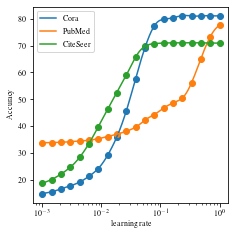

In [25]:
# change 
param = r"learning rate"
print(f"what is the best {param}?")
lst_param = np.logspace(-3, 0, 20, endpoint=True)

# data
lst_name_dataset = ['Cora', 'PubMed', 'CiteSeer']

# estimation
num_epochs = 200
log_epoch = 1
num_runs = 10

# plot
textwidth = 239.39438*0.0138888889
figsize=(textwidth, textwidth)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()

for name_dataset in lst_name_dataset:
    
    # dataset
    dataset = Planetoid(root='datasets', name=name_dataset)
    data = dataset[0].to(device)
    
    # model
    dim_x = dataset.num_node_features
    dim_h = 16
    dim_y = dataset.num_classes
    lst_dim = [dim_x, dim_h, dim_y]
    
    lst_acc = []
    for p in lst_param:
        torch.manual_seed(seed)
        
        lst_acc_run = []
        for _ in range(num_runs):
            t = time.time()
            
            # change
            out = sgd(GCN(lst_dim).to(device), data, 
                            lr=p, num_epochs=num_epochs, log_epoch=log_epoch)
            
            lst_acc_run.append(out['lst_acc_test'][np.argmax(out['lst_acc_val'])])
        lst_acc.append(np.mean(lst_acc_run))
        
        print(f"dataset: {name_dataset},", 
              f"time: {time.time() - t: .2f} (s),",
              f"accuracy test: {lst_acc[-1]: .2f},",
              f"{param}: {p : .3f},")
        
    print(f"dataset: {name_dataset},", 
          f"accuracy test: {np.max(lst_acc): .2f},", 
          f"loss test": {np.max(lst_acc): .2f}
          f"{param}: {lst_param[np.argmax(lst_acc)]: .3f},")

    x = np.linspace(lst_param.min(), lst_param.max(), 100*len(lst_param))
    spl = make_interp_spline(lst_param, lst_acc, k=3)
    y = spl(x)
    ax.plot(x, y, label=name_dataset)
    ax.scatter(lst_param, lst_acc)

ax.set_xscale('log')
ax.set_xlabel(param)
ax.set_ylabel("Accuracy")
plt.legend()
plt.savefig(f"accuracy-{param}.pdf")
plt.show()

what is the best alpha?


KeyboardInterrupt: 

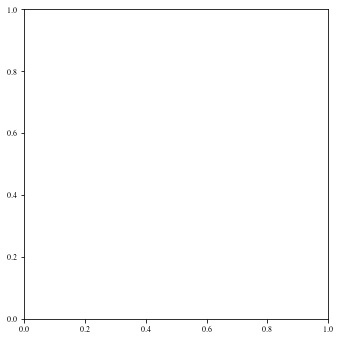

In [9]:
lst_name_dataset = ['Cora', 'PubMed', 'CiteSeer']

# estimation
num_epochs = 200
lr = .01
log_epoch = 1

print("what is the best alpha?")
lst_alpha = np.logspace(-3, 0, 20, endpoint=True)
num_runs = 1

figsize=(4.77, 4.77)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
for name_dataset in lst_name_dataset:
    
    # dataset
    dataset = Planetoid(root='datasets', name=name_dataset)
    data = dataset[0].to(device)
    
    # model
    dim_x = dataset.num_node_features
    dim_h = 16
    dim_y = dataset.num_classes
    lst_dim = [dim_x, dim_h, dim_y]
    
    lst_acc_alpha = []
    for alpha in lst_alpha:
        torch.manual_seed(seed)
        
        lst_acc_run = []
        for _ in range(num_runs):
            t = time.time()
            out_ngd_kfa = ngd_kfa(GCN(lst_dim).to(device), data, 
                            lr=lr, num_epochs=num_epochs, log_epoch=log_epoch, alpha=alpha)
            lst_acc_run.append(out_ngd_kfa['lst_acc_test'][np.argmax(out_ngd_kfa['lst_acc_val'])])
        lst_acc_alpha.append(np.mean(lst_acc_run))
        
        print(f"dataset: {name_dataset}", 
              f"time: {time.time() - t: .2f} (s)",
              f"accuracy test: {lst_acc_alpha[-1]: .2f}",
              f"alpha: {alpha : .3f}")
        
    print(f"dataset: {name_dataset}", 
          f"accuracy test: {np.max(lst_acc_alpha): .2f}", 
          f"alpha: {lst_alpha[np.argmax(lst_acc_alpha)]: .3f}")

    x = np.linspace(lst_alpha.min(), lst_alpha.max(), 100*len(lst_alpha))
    spl = make_interp_spline(lst_alpha, lst_acc_alpha, k=3)
    y = spl(x)
    ax.plot(x, y, label=name_dataset)
    ax.scatter(lst_alpha, lst_acc_alpha)

ax.set_xscale('log')
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_alpha.pdf")
plt.show()

Adam vs Natural Gradient Descent (KFA)
Adam time:  0.54 accuracy test:  79.900
Natural Gradient Descent (KFA) time:  9.69 accuracy test:  82.100


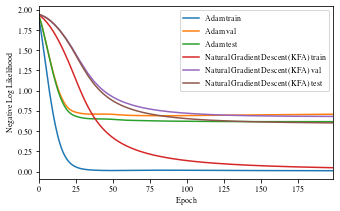

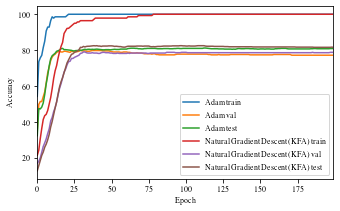

Adam time:  0.70 accuracy test:  77.000
Natural Gradient Descent (KFA) time:  7.04 accuracy test:  78.800


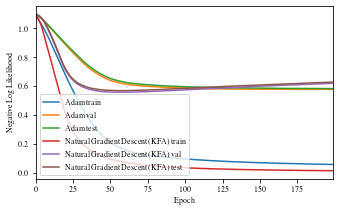

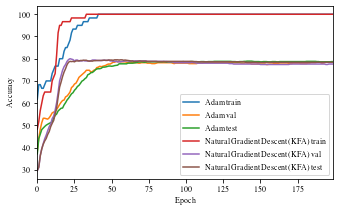

Adam time:  0.63 accuracy test:  68.000
Natural Gradient Descent (KFA) time:  23.14 accuracy test:  70.500


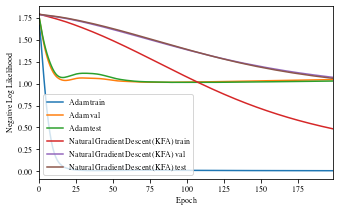

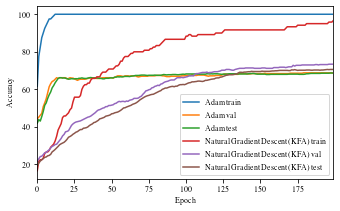

In [20]:
#%%script false --no-raise-error

print("Adam vs Natural Gradient Descent (KFA)")

# estimation
num_epochs = 200
lr = .01
log_epoch = 1
figsize = (4.77, 4.77/1.6)

for name_dataset in lst_name_dataset:
    
    # dataset
    dataset = Planetoid(root='datasets', name=name_dataset)
    data = dataset[0].to(device)
    
    # model
    dim_x = dataset.num_node_features
    dim_h = 16
    dim_y = dataset.num_classes
    lst_dim = [dim_x, dim_h, dim_y]

    if name_dataset == 'Cora':
        alpha = .1
    if name_dataset == 'PubMed':
        alpha = .03
    if name_dataset == 'CiteSeer':
        alpha = .3

    torch.manual_seed(seed)
    t = time.time()
    out_adam = adam(GCN(lst_dim).to(device), data, 
                    lr=lr, num_epochs=num_epochs, log_epoch=log_epoch)
    print("Adam", 
          f"time: {time.time() - t: .2f}", 
          f"accuracy test: {out_adam['lst_acc_test'][np.argmax(out_adam['lst_acc_val'])]: .3f}")

    torch.manual_seed(seed)
    t = time.time()
    out_ngd_kfa = ngd_kfa(GCN(lst_dim).to(device), data, 
                    lr=lr, num_epochs=num_epochs, log_epoch=log_epoch, alpha=alpha)
    print("Natural Gradient Descent (KFA)", 
          f"time: {time.time() - t: .2f}", 
          f"accuracy test: {out_ngd_kfa['lst_acc_test'][np.argmax(out_ngd_kfa['lst_acc_val'])]: .3f}")

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.plot(out_adam["lst_loss_train"], label="Adam train")
    ax.plot(out_adam["lst_loss_val"], label="Adam val")
    ax.plot(out_adam["lst_loss_test"], label="Adam test")
    ax.plot(out_ngd_kfa["lst_loss_train"], label="Natural Gradient Descent (KFA) train")
    ax.plot(out_ngd_kfa["lst_loss_val"], label="Natural Gradient Descent (KFA) val")
    ax.plot(out_ngd_kfa["lst_loss_test"], label="Natural Gradient Descent (KFA) test")
    ax.set_xlim([0, num_epochs-1])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Negative Log Likelihood")
    plt.legend()
    plt.savefig(f"nll_{name_dataset}.pdf")
    plt.show()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.plot(out_adam["lst_acc_train"], label="Adam train")
    ax.plot(out_adam["lst_acc_val"], label="Adam val")
    ax.plot(out_adam["lst_acc_test"], label="Adam test")
    ax.plot(out_ngd_kfa["lst_acc_train"], label="Natural Gradient Descent (KFA) train")
    ax.plot(out_ngd_kfa["lst_acc_val"], label="Natural Gradient Descent (KFA) val")
    ax.plot(out_ngd_kfa["lst_acc_test"], label="Natural Gradient Descent (KFA) test")

    ax.set_xlim([0, num_epochs-1])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"acc_{name_dataset}.pdf")
    plt.show()

In [11]:
# all three on gcn 
lst_name_dataset = ['Cora', 'PubMed', 'CiteSeer']
# cora on spline
#lst_name_dataset = ['Cora']

num_epochs = 200
lr = .01
log_epoch = 1

print("Adam vs Natural Gradient Descent (KFA)")

num_runs = 10

for name_dataset in lst_name_dataset:
    
    # dataset
    dataset = Planetoid(root='datasets', name=name_dataset)

    # spline
    #dataset = Planetoid(root='datasets', name=name_dataset,
    #                    transform=T.TargetIndegree())
    data = dataset[0].to(device)
    # model
    dim_x = dataset.num_node_features
    dim_h = 16
    dim_y = dataset.num_classes
    lst_dim = [dim_x, dim_h, dim_y]
    
    # .6, .2, .2
    #idx_train = int(.6*data.num_nodes)
    #idx_val = int(.8*data.num_nodes)
    

#     data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
#     data.train_mask[:data.num_nodes - 1000] = 1
#     data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
#     data.val_mask[data.num_nodes - 1000:data.num_nodes - 500] = 1
#     data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
#     data.test_mask[data.num_nodes - 500:] = 1

    for lr in np.logspace(-2, 2, 10, endpoint=True):
        torch.manual_seed(seed)
        print(f"learning rate: {lr: .3f}")
        # Adam
        lst_acc = []

        for _ in range(num_runs):

    #         idx = torch.randperm(data.num_nodes)
    #         data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    #         data.train_mask[idx[:idx_train]] = 1

    #         data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    #         data.val_mask[idx[idx_train:idx_val]] = 1

    #         data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    #         data.test_mask[idx[idx_val:]] = 1

            t = time.time()
            out_adam = adam(GCN(lst_dim).to(device), data, 
                            lr=lr, num_epochs=num_epochs, log_epoch=log_epoch)

            #out_adam = adam(SCN(lst_dim).to(device), data, 
            #                lr=lr, num_epochs=num_epochs, log_epoch=log_epoch)

            lst_acc.append(out_adam['lst_acc_test'][np.argmax(out_adam['lst_acc_val'])])

        cb = stats.sem(lst_acc) * stats.t.ppf((1 + 0.95) / 2, len(lst_acc) - 1)
        print("Adam", 
            f"dataset: {name_dataset}", 
            f"accuracy: {np.mean(lst_acc): .2f}", 
            f"cb: {cb: .1f}")

#     # Natural Gradient Descent (KFA)
#     if name_dataset == 'Cora':
#         alpha = .1
#         #alpha = .05
#         lst_alpha = [.05, .1, .15]
#     if name_dataset == 'PubMed':
#         alpha = .03
#         #alpha = .02
#         lst_alpha = [.01, .02, .03, .04, .05]
#     if name_dataset == 'CiteSeer':
#         alpha = .3
#         #alpha = .15
#         lst_alpha = [.1, .2, .3]
#     #for alpha in lst_alpha:#np.logspace(-2, 0, 10, endpoint=True)
#         #print(alpha)

#     lst_acc = []
#     for _ in range(num_runs):

# #             idx = torch.randperm(data.num_nodes)
# #             data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# #             data.train_mask[idx[:idx_train]] = 1

# #             data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# #             data.val_mask[idx[idx_train:idx_val]] = 1

# #             data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# #             data.test_mask[idx[idx_val:]] = 1

#         t = time.time()
#         out_ngd_kfa = ngd_kfa(GCN(lst_dim).to(device), data, 
#                         lr=lr, num_epochs=num_epochs, log_epoch=log_epoch, alpha=alpha)

#         # alpha = .05
#         #out_ngd_kfa = ngd_kfa(SCN(lst_dim).to(device), data, 
#         #                lr=lr, num_epochs=num_epochs, log_epoch=log_epoch, alpha=alpha)

#         lst_acc.append(out_ngd_kfa['lst_acc_test'][np.argmax(out_ngd_kfa['lst_acc_val'])])
#         print(lst_acc)
#     cb = stats.sem(lst_acc) * stats.t.ppf((1 + 0.95) / 2, len(lst_acc) - 1)
#     print("Natural Gradient Descent (KFA)", 
#         f"dataset: {name_dataset}", 
#         f"accuracy: {np.mean(lst_acc): .2f}", 
#         f"cb: {cb: .1f}")

Adam vs Natural Gradient Descent (KFA)
learning rate:  0.010
Adam dataset: Cora accuracy:  80.00 cb:  0.9
learning rate:  0.028
Adam dataset: Cora accuracy:  80.20 cb:  0.7
learning rate:  0.077
Adam dataset: Cora accuracy:  79.72 cb:  1.1
learning rate:  0.215
Adam dataset: Cora accuracy:  80.20 cb:  0.3
learning rate:  0.599
Adam dataset: Cora accuracy:  77.70 cb:  1.5
learning rate:  1.668
Adam dataset: Cora accuracy:  68.57 cb:  2.3
learning rate:  4.642
Adam dataset: Cora accuracy:  54.86 cb:  3.5
learning rate:  12.915
Adam dataset: Cora accuracy:  50.20 cb:  4.8
learning rate:  35.938
Adam dataset: Cora accuracy:  49.55 cb:  4.6
learning rate:  100.000
Adam dataset: Cora accuracy:  48.84 cb:  3.4
learning rate:  0.010
Adam dataset: PubMed accuracy:  77.69 cb:  0.5
learning rate:  0.028
Adam dataset: PubMed accuracy:  78.12 cb:  0.2
learning rate:  0.077
Adam dataset: PubMed accuracy:  78.31 cb:  0.3
learning rate:  0.215
Adam dataset: PubMed accuracy:  78.03 cb:  0.4
learning ra

learning rate vs alpha
[51.2]
[51.2, 41.9]
[51.2, 41.9, 76.9]
[51.2, 41.9, 76.9, 79.3]
[51.2, 41.9, 76.9, 79.3, 78.9]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7, 10.5]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7, 10.5, 46.1]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7, 10.5, 46.1, 43.4]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7, 10.5, 46.1, 43.4, 70.9]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7, 10.5, 46.1, 43.4, 70.9, 78.4]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7, 10.5, 46.1, 43.4, 70.9, 78.4, 80.4]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7, 10.5, 46.1, 43.4, 70.9, 78.4, 80.4, 81.2]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2, 24.0, 13.7, 10.5, 46.1, 43.4, 70.9, 78.4, 80.4, 81.2, 81.9]
[51.2, 41.9, 76.9, 79.3, 78.9, 80.6, 72.2,

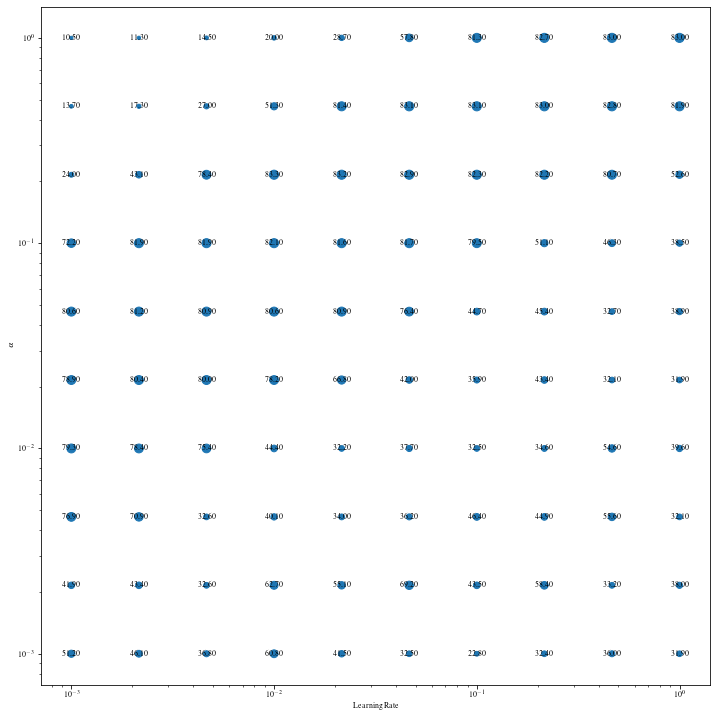

[50.8]
[50.8, 76.8]
[50.8, 76.8, 77.2]
[50.8, 76.8, 77.2, 78.7]
[50.8, 76.8, 77.2, 78.7, 78.6]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9, 75.6]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9, 75.6, 71.9]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9, 75.6, 71.9, 77.2]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9, 75.6, 71.9, 77.2, 78.9]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9, 75.6, 71.9, 77.2, 78.9, 78.7]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9, 75.6, 71.9, 77.2, 78.9, 78.7, 75.5]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9, 75.6, 71.9, 77.2, 78.9, 78.7, 75.5, 42.8]
[50.8, 76.8, 77.2, 78.7, 78.6, 48.3, 37.1, 32.1, 31.4, 30.9, 75.6

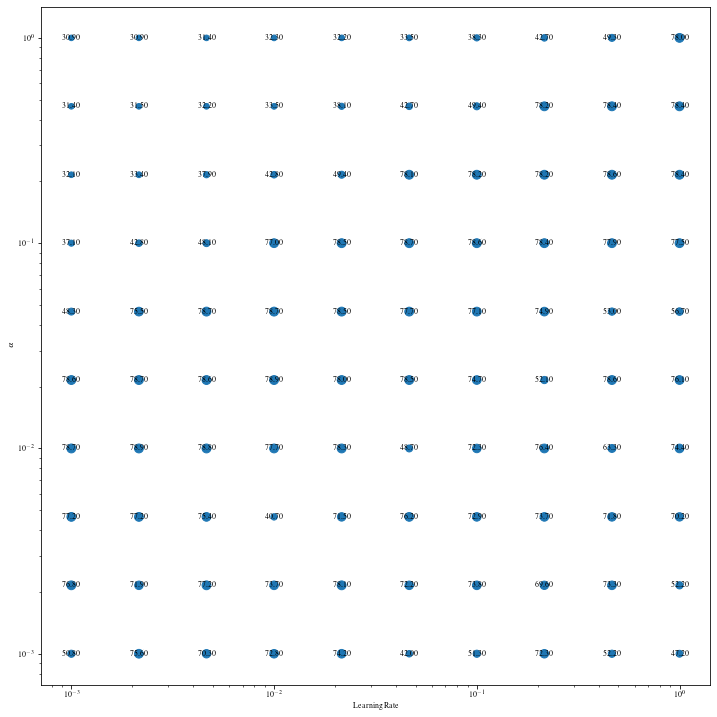

[28.5]
[28.5, 36.3]
[28.5, 36.3, 39.0]
[28.5, 36.3, 39.0, 67.3]
[28.5, 36.3, 39.0, 67.3, 67.8]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5, 27.6]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5, 27.6, 25.2]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5, 27.6, 25.2, 28.2]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5, 27.6, 25.2, 28.2, 63.2]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5, 27.6, 25.2, 28.2, 63.2, 68.2]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5, 27.6, 25.2, 28.2, 63.2, 68.2, 68.7]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5, 27.6, 25.2, 28.2, 63.2, 68.2, 68.7, 70.0]
[28.5, 36.3, 39.0, 67.3, 67.8, 68.7, 67.7, 40.9, 26.1, 21.5, 27.6

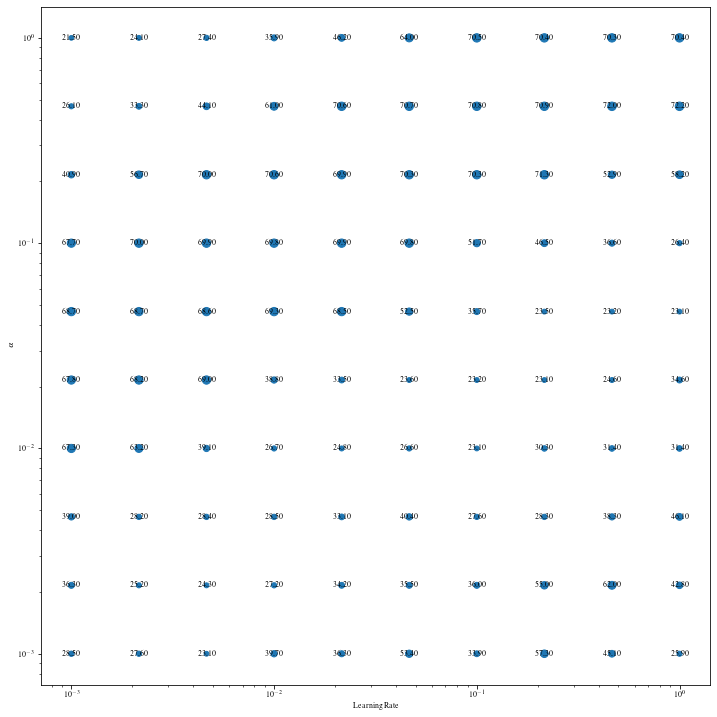

In [116]:
#%%script false --no-raise-error

print("learning rate vs alpha")

lst_lr = np.logspace(-3, 0, 10, endpoint=True)
lst_alpha = np.logspace(-3, 0, 10, endpoint=True)

num_epochs = 200
figsize=(20, 20)
for name_dataset in lst_name_dataset:
    
    # dataset
    dataset = Planetoid(root='datasets', name=name_dataset)
    data = dataset[0].to(device)
    
    # model
    dim_x = dataset.num_node_features
    dim_h = 16
    dim_y = dataset.num_classes
    lst_dim = [dim_x, dim_h, dim_y]
    
    x, y = [], []
    lst_acc = []
    for lr in lst_lr:
        for alpha in lst_alpha:
            torch.manual_seed(seed)
            x.append(lr)
            y.append(alpha)
            
            out_ngd_kfa = ngd_kfa(GCN(lst_dim).to(device), data, 
                        lr=lr, num_epochs=num_epochs, log_epoch=log_epoch, alpha=alpha)
            
            lst_acc.append(out_ngd_kfa['lst_acc_test'][np.argmax(out_ngd_kfa['lst_acc_val'])])
            print(lst_acc)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.scatter(x, y, s=lst_acc)
    
    for i, txt in enumerate(lst_acc):
        ax.annotate(f"{txt: .2f}", (x[i], y[i]), textcoords="offset points", xytext=(0, 0), ha='center', va='center')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel(r"$\alpha$")

    plt.savefig(f"lr_alpha_{name_dataset}.pdf")
    plt.show()

In [108]:
from torch.optim.optimizer import Optimizer

class EKFAC(Optimizer):

    def __init__(self, net, eps, sua=False, ra=False, update_freq=1,
                 alpha=1.):
        """ EKFAC Preconditionner for Linear and Conv2d layers.
        Computes the EKFAC of the second moment of the gradients.
        It works for Linear and Conv2d layers and silently skip other layers.
        Args:
            net (torch.nn.Module): Network to precondition.
            eps (float): Tikhonov regularization parameter for the inverses.
            sua (bool): Applies SUA approximation.
            ra (bool): Computes stats using a running average of averaged gradients
                instead of using a intra minibatch estimate
            update_freq (int): Perform inverses every update_freq updates.
            alpha (float): Running average parameter
        """
        self.eps = eps
        self.sua = sua
        self.ra = ra
        self.update_freq = update_freq
        self.alpha = alpha
        self.params = []
        self._fwd_handles = []
        self._bwd_handles = []
        self._iteration_counter = 0
        if not self.ra and self.alpha != 1.:
            raise NotImplementedError
        for mod in net.modules():
            mod_class = mod.__class__.__name__
            if mod_class in ['Linear', 'Conv2d']:
                handle = mod.register_forward_pre_hook(self._save_input)
                self._fwd_handles.append(handle)
                handle = mod.register_backward_hook(self._save_grad_output)
                self._bwd_handles.append(handle)
                params = [mod.weight]
                if mod.bias is not None:
                    params.append(mod.bias)
                d = {'params': params, 'mod': mod, 'layer_type': mod_class}
                if mod_class == 'Conv2d':
                    if not self.sua:
                        # Adding gathering filter for convolution
                        d['gathering_filter'] = self._get_gathering_filter(mod)
                self.params.append(d)
        super(EKFAC, self).__init__(self.params, {})

    def step(self, update_stats=True, update_params=True):
        """Performs one step of preconditioning."""
        for group in self.param_groups:
            # Getting parameters
            if len(group['params']) == 2:
                weight, bias = group['params']
            else:
                weight = group['params'][0]
                bias = None
            state = self.state[weight]
            # Update convariances and inverses
            if self._iteration_counter % self.update_freq == 0:
                self._compute_kfe(group, state)
            # Preconditionning
            if group['layer_type'] == 'Conv2d' and self.sua:
                if self.ra:
                    self._precond_sua_ra(weight, bias, group, state)
                else:
                    self._precond_intra_sua(weight, bias, group, state)
            else:
                if self.ra:
                    self._precond_ra(weight, bias, group, state)
                else:
                    self._precond_intra(weight, bias, group, state)
        self._iteration_counter += 1

    def _save_input(self, mod, i):
        """Saves input of layer to compute covariance."""
        self.state[mod]['x'] = i[0]

    def _save_grad_output(self, mod, grad_input, grad_output):
        """Saves grad on output of layer to compute covariance."""
        self.state[mod]['gy'] = grad_output[0] * grad_output[0].size(0)

    def _precond_ra(self, weight, bias, group, state):
        """Applies preconditioning."""
        kfe_x = state['kfe_x']
        kfe_gy = state['kfe_gy']
        m2 = state['m2']
        g = weight.grad.data
        s = g.shape
        bs = self.state[group['mod']]['x'].size(0)
        if group['layer_type'] == 'Conv2d':
            g = g.contiguous().view(s[0], s[1]*s[2]*s[3])
        if bias is not None:
            gb = bias.grad.data
            g = torch.cat([g, gb.view(gb.shape[0], 1)], dim=1)
        g_kfe = torch.mm(torch.mm(kfe_gy.t(), g), kfe_x)
        m2.mul_(self.alpha).add_((1. - self.alpha) * bs, g_kfe**2)
        g_nat_kfe = g_kfe / (m2 + self.eps)
        g_nat = torch.mm(torch.mm(kfe_gy, g_nat_kfe), kfe_x.t())
        if bias is not None:
            gb = g_nat[:, -1].contiguous().view(*bias.shape)
            bias.grad.data = gb
            g_nat = g_nat[:, :-1]
        g_nat = g_nat.contiguous().view(*s)
        weight.grad.data = g_nat

    def _precond_intra(self, weight, bias, group, state):
        """Applies preconditioning."""
        kfe_x = state['kfe_x']
        kfe_gy = state['kfe_gy']
        mod = group['mod']
        x = self.state[mod]['x']
        gy = self.state[mod]['gy']
        g = weight.grad.data
        s = g.shape
        s_x = x.size()
        s_cin = 0
        s_gy = gy.size()
        bs = x.size(0)
        if group['layer_type'] == 'Conv2d':
            x = F.conv2d(x, group['gathering_filter'],
                         stride=mod.stride, padding=mod.padding,
                         groups=mod.in_channels)
            s_x = x.size()
            x = x.data.permute(1, 0, 2, 3).contiguous().view(x.shape[1], -1)
            if mod.bias is not None:
                ones = torch.ones_like(x[:1])
                x = torch.cat([x, ones], dim=0)
                s_cin = 1 # adding a channel in dim for the bias
            # intra minibatch m2
            x_kfe = torch.mm(kfe_x.t(), x).view(s_x[1]+s_cin, -1, s_x[2], s_x[3]).permute(1, 0, 2, 3)
            gy = gy.permute(1, 0, 2, 3).contiguous().view(s_gy[1], -1)
            gy_kfe = torch.mm(kfe_gy.t(), gy).view(s_gy[1], -1, s_gy[2], s_gy[3]).permute(1, 0, 2, 3)
            m2 = torch.zeros((s[0], s[1]*s[2]*s[3]+s_cin), device=g.device)
            g_kfe = torch.zeros((s[0], s[1]*s[2]*s[3]+s_cin), device=g.device)
            for i in range(x_kfe.size(0)):
                g_this = torch.mm(gy_kfe[i].view(s_gy[1], -1),
                                  x_kfe[i].permute(1, 2, 0).view(-1, s_x[1]+s_cin))
                m2 += g_this**2
            m2 /= bs
            g_kfe = torch.mm(gy_kfe.permute(1, 0, 2, 3).view(s_gy[1], -1),
                             x_kfe.permute(0, 2, 3, 1).contiguous().view(-1, s_x[1]+s_cin)) / bs
            ## sanity check did we obtain the same grad ?
            # g = torch.mm(torch.mm(kfe_gy, g_kfe), kfe_x.t())
            # gb = g[:,-1]
            # gw = g[:,:-1].view(*s)
            # print('bias', torch.dist(gb, bias.grad.data))
            # print('weight', torch.dist(gw, weight.grad.data))
            ## end sanity check
            g_nat_kfe = g_kfe / (m2 + self.eps)
            g_nat = torch.mm(torch.mm(kfe_gy, g_nat_kfe), kfe_x.t())
            if bias is not None:
                gb = g_nat[:, -1].contiguous().view(*bias.shape)
                bias.grad.data = gb
                g_nat = g_nat[:, :-1]
            g_nat = g_nat.contiguous().view(*s)
            weight.grad.data = g_nat
        else:
            if bias is not None:
                ones = torch.ones_like(x[:, :1])
                x = torch.cat([x, ones], dim=1)
            x_kfe = torch.mm(x, kfe_x)
            gy_kfe = torch.mm(gy, kfe_gy)
            m2 = torch.mm(gy_kfe.t()**2, x_kfe**2) / bs
            g_kfe = torch.mm(gy_kfe.t(), x_kfe) / bs
            g_nat_kfe = g_kfe / (m2 + self.eps)
            g_nat = torch.mm(torch.mm(kfe_gy, g_nat_kfe), kfe_x.t())
            if bias is not None:
                gb = g_nat[:, -1].contiguous().view(*bias.shape)
                bias.grad.data = gb
                g_nat = g_nat[:, :-1]
            g_nat = g_nat.contiguous().view(*s)
            weight.grad.data = g_nat

    def _precond_sua_ra(self, weight, bias, group, state):
        """Preconditioning for KFAC SUA."""
        kfe_x = state['kfe_x']
        kfe_gy = state['kfe_gy']
        m2 = state['m2']
        g = weight.grad.data
        s = g.shape
        bs = self.state[group['mod']]['x'].size(0)
        mod = group['mod']
        if bias is not None:
            gb = bias.grad.view(-1, 1, 1, 1).expand(-1, -1, s[2], s[3])
            g = torch.cat([g, gb], dim=1)
        g_kfe = self._to_kfe_sua(g, kfe_x, kfe_gy)
        m2.mul_(self.alpha).add_((1. - self.alpha) * bs, g_kfe**2)
        g_nat_kfe = g_kfe / (m2 + self.eps)
        g_nat = self._to_kfe_sua(g_nat_kfe, kfe_x.t(), kfe_gy.t())
        if bias is not None:
            gb = g_nat[:, -1, s[2]//2, s[3]//2]
            bias.grad.data = gb
            g_nat = g_nat[:, :-1]
        weight.grad.data = g_nat

    def _precond_intra_sua(self, weight, bias, group, state):
        """Preconditioning for KFAC SUA."""
        kfe_x = state['kfe_x']
        kfe_gy = state['kfe_gy']
        mod = group['mod']
        x = self.state[mod]['x']
        gy = self.state[mod]['gy']
        g = weight.grad.data
        s = g.shape
        s_x = x.size()
        s_gy = gy.size()
        s_cin = 0
        bs = x.size(0)
        if bias is not None:
            ones = torch.ones_like(x[:,:1])
            x = torch.cat([x, ones], dim=1)
            s_cin += 1
        # intra minibatch m2
        x = x.permute(1, 0, 2, 3).contiguous().view(s_x[1]+s_cin, -1)
        x_kfe = torch.mm(kfe_x.t(), x).view(s_x[1]+s_cin, -1, s_x[2], s_x[3]).permute(1, 0, 2, 3)
        gy = gy.permute(1, 0, 2, 3).contiguous().view(s_gy[1], -1)
        gy_kfe = torch.mm(kfe_gy.t(), gy).view(s_gy[1], -1, s_gy[2], s_gy[3]).permute(1, 0, 2, 3)
        m2 = torch.zeros((s[0], s[1]+s_cin, s[2], s[3]), device=g.device)
        g_kfe = torch.zeros((s[0], s[1]+s_cin, s[2], s[3]), device=g.device)
        for i in range(x_kfe.size(0)):
            g_this = grad_wrt_kernel(x_kfe[i:i+1], gy_kfe[i:i+1], mod.padding, mod.stride)
            m2 += g_this**2
        m2 /= bs
        g_kfe = grad_wrt_kernel(x_kfe, gy_kfe, mod.padding, mod.stride) / bs
        ## sanity check did we obtain the same grad ?
        # g = self._to_kfe_sua(g_kfe, kfe_x.t(), kfe_gy.t())
        # gb = g[:, -1, s[2]//2, s[3]//2]
        # gw = g[:,:-1].view(*s)
        # print('bias', torch.dist(gb, bias.grad.data))
        # print('weight', torch.dist(gw, weight.grad.data))
        ## end sanity check
        g_nat_kfe = g_kfe / (m2 + self.eps)
        g_nat = self._to_kfe_sua(g_nat_kfe, kfe_x.t(), kfe_gy.t())
        if bias is not None:
            gb = g_nat[:, -1, s[2]//2, s[3]//2]
            bias.grad.data = gb
            g_nat = g_nat[:, :-1]
        weight.grad.data = g_nat

    def _compute_kfe(self, group, state):
        """Computes the covariances."""
        mod = group['mod']
        x = self.state[group['mod']]['x']
        gy = self.state[group['mod']]['gy']
        # Computation of xxt
        if group['layer_type'] == 'Conv2d':
            if not self.sua:
                x = F.conv2d(x, group['gathering_filter'],
                             stride=mod.stride, padding=mod.padding,
                             groups=mod.in_channels)
            x = x.data.permute(1, 0, 2, 3).contiguous().view(x.shape[1], -1)
        else:
            x = x.data.t()
        if mod.bias is not None:
            ones = torch.ones_like(x[:1])
            x = torch.cat([x, ones], dim=0)
        xxt = torch.mm(x, x.t()) / float(x.shape[1])
        Ex, state['kfe_x'] = torch.symeig(xxt, eigenvectors=True)
        # Computation of ggt
        if group['layer_type'] == 'Conv2d':
            gy = gy.data.permute(1, 0, 2, 3)
            state['num_locations'] = gy.shape[2] * gy.shape[3]
            gy = gy.contiguous().view(gy.shape[0], -1)
        else:
            gy = gy.data.t()
            state['num_locations'] = 1
        ggt = torch.mm(gy, gy.t()) / float(gy.shape[1])
        Eg, state['kfe_gy'] = torch.symeig(ggt, eigenvectors=True)
        state['m2'] = Eg.unsqueeze(1) * Ex.unsqueeze(0) * state['num_locations']
        if group['layer_type'] == 'Conv2d' and self.sua:
            ws = group['params'][0].grad.data.size()
            state['m2'] = state['m2'].view(Eg.size(0), Ex.size(0), 1, 1).expand(-1, -1, ws[2], ws[3])

    def _get_gathering_filter(self, mod):
        """Convolution filter that extracts input patches."""
        kw, kh = mod.kernel_size
        g_filter = mod.weight.data.new(kw * kh * mod.in_channels, 1, kw, kh)
        g_filter.fill_(0)
        for i in range(mod.in_channels):
            for j in range(kw):
                for k in range(kh):
                    g_filter[k + kh*j + kw*kh*i, 0, j, k] = 1
        return g_filter

    def _to_kfe_sua(self, g, vx, vg):
        """Project g to the kfe"""
        sg = g.size()
        g = torch.mm(vg.t(), g.view(sg[0], -1)).view(vg.size(1), sg[1], sg[2], sg[3])
        g = torch.mm(g.permute(0, 2, 3, 1).contiguous().view(-1, sg[1]), vx)
        g = g.view(vg.size(1), sg[2], sg[3], vx.size(1)).permute(0, 3, 1, 2)
        return g

    def __del__(self):
        for handle in self._fwd_handles + self._bwd_handles:
            handle.remove()


def grad_wrt_kernel(a, g, padding, stride, target_size=None):
    gk = F.conv2d(a.transpose(0, 1), g.transpose(0, 1).contiguous(),
                  padding=padding, dilation=stride).transpose(0, 1)
    if target_size is not None and target_size != gk.size():
        return gk[:, :, :target_size[2], :target_size[3]].contiguous()
    return gk

def ekfac(model, data, **kwargs):
    print(model)
    model.train()
    
    lst_loss_train, lst_loss_val, lst_loss_test = [], [], []
    lst_acc_train, lst_acc_val, lst_acc_test = [], [], []
    
    preconditioner = EKFAC(model, 0.1, update_freq=100)
    
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4,
                      lr=kwargs['lr'])
    
    for epoch in range(kwargs['num_epochs']):
        optimizer.zero_grad()
        a2, _ = model(data)
        loss = F.nll_loss(a2[data.train_mask], data.y[data.train_mask])
        loss.backward()
        
        preconditioner.step()
        optimizer.step()
        
        if epoch%kwargs['log_epoch']==0:
            model.eval()
            a2, _ = model(data)
            correct = a2.argmax(1).eq(data.y)
            
            lst_loss_train.append(F.nll_loss(a2[data.train_mask], data.y[data.train_mask]).item())
            lst_acc_train.append(float(100*correct[data.train_mask].sum().item())
                                /(data.train_mask.sum().item()))
            
            lst_loss_val.append(F.nll_loss(a2[data.val_mask], data.y[data.val_mask]).item())
            lst_acc_val.append(float(100*correct[data.val_mask].sum().item())
                                /(data.val_mask.sum().item()))
            
            lst_loss_test.append(F.nll_loss(a2[data.test_mask], data.y[data.test_mask]).item())
            lst_acc_test.append(float(100*correct[data.test_mask].sum().item())
                                /(data.test_mask.sum().item()))        
            
    return {"lst_loss_train": lst_loss_train, "lst_acc_train": lst_acc_train, 
            "lst_loss_val": lst_loss_val, "lst_acc_val": lst_acc_val, 
            "lst_loss_test": lst_loss_test, "lst_acc_test": lst_acc_test}

lst_name_dataset = ['Cora', 'PubMed', 'CiteSeer']
# cora on spline
#lst_name_dataset = ['Cora']

num_epochs = 200
lr = .01
log_epoch = 1

print("Adam vs Natural Gradient Descent (KFA)")

num_runs = 10

for name_dataset in lst_name_dataset:
    
    
    
    # dataset
    dataset = Planetoid(root='datasets', name=name_dataset)

    # spline
    #dataset = Planetoid(root='datasets', name=name_dataset,
    #                    transform=T.TargetIndegree())
    data = dataset[0].to(device)
    # model
    dim_x = dataset.num_node_features
    dim_h = 16
    dim_y = dataset.num_classes
    lst_dim = [dim_x, dim_h, dim_y]
    
    # .6, .2, .2
    #idx_train = int(.6*data.num_nodes)
    #idx_val = int(.8*data.num_nodes)
    

#     data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
#     data.train_mask[:data.num_nodes - 1000] = 1
#     data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
#     data.val_mask[data.num_nodes - 1000:data.num_nodes - 500] = 1
#     data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
#     data.test_mask[data.num_nodes - 500:] = 1

    for lr in np.logspace(-2, 0, 10, endpoint=True):
        torch.manual_seed(seed)
        print(lr)
        # Adam
        lst_acc = []

        for _ in range(num_runs):

    #         idx = torch.randperm(data.num_nodes)
    #         data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    #         data.train_mask[idx[:idx_train]] = 1

    #         data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    #         data.val_mask[idx[idx_train:idx_val]] = 1

    #         data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    #         data.test_mask[idx[idx_val:]] = 1

            t = time.time()
            out_adam = ekfac(GCN(lst_dim).to(device), data, 
                            lr=lr, num_epochs=num_epochs, log_epoch=log_epoch)

            #out_adam = adam(SCN(lst_dim).to(device), data, 
            #                lr=lr, num_epochs=num_epochs, log_epoch=log_epoch)

            lst_acc.append(out_adam['lst_acc_test'][np.argmax(out_adam['lst_acc_val'])])

        cb = stats.sem(lst_acc) * stats.t.ppf((1 + 0.95) / 2, len(lst_acc) - 1)
        print("Adam", 
            f"dataset: {name_dataset}", 
            f"accuracy: {np.mean(lst_acc): .2f}", 
            f"cb: {cb: .1f}")

Adam vs Natural Gradient Descent (KFA)
0.01
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


ValueError: optimizer got an empty parameter list